<a href="https://colab.research.google.com/github/JoanesMiranda/Machine-learning/blob/master/Aplicando_Redes_Neural_Recorrente_a_base_de_dados_Twitter_em_portugues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unifacisa Centro Universitario

- **Curso:** Pós-Graduação em Ciência de Dados.
- **Disciplina:**  Processamento de Linguagem Natural.
- **Professor:** Jones Granatyr.
- **Aluno:** Joanes Miranda de Souto.


# Etapa 1: Importação das bibliotecas

In [76]:
# Teoria CNN para textos
# Classificação de sentimentos com CNN
# Teoria RNN
# Classificação de sentimentos com RNN
# Geração de novos textos com RNN

# Transformer
# Tradutor de idiomas: EN -> PT
# BERT
# Q&A
# Orange

# Base de dados
# https://drive.google.com/file/d/1dEhKrvPTli4NK7Aaa2lACx2NvjVwWf9d/view?usp=sharing

import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import spacy
import matplotlib.pyplot as plt

In [77]:
!python3 -m spacy download pt

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [78]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [79]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [80]:
train_data = pd.read_csv('/content/Train50.csv', delimiter=";")

In [81]:
train_data.shape

(50000, 5)

In [82]:
train_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [83]:
train_data.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


In [84]:
train_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


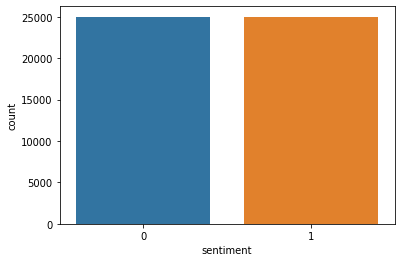

In [85]:
sns.countplot(train_data.sentiment);

In [86]:
test_data = pd.read_csv("/content/Test.csv",delimiter=";")

In [87]:
test_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [88]:
test_data.shape

(5000, 5)

In [89]:
test_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


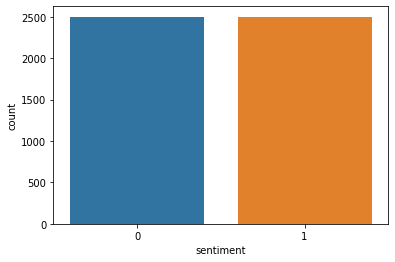

In [90]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [91]:
data = train_data

In [92]:
data.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [93]:
data.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


In [94]:
X = data.iloc[:, 0].values

In [95]:
X

array(['@Laranjito76 A pessoa certa para isso seria o vale e azevedo :)',
       '@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)',
       'Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D',
       ...,
       'eu te amo tanto minja vidinha meu bem mais precioso me desculpa ser uma péssima utted mas eu te amo mais que tudo nem palavras é capaz de explicar o tamanho do amor que sinto por ti :(((( https://t.co/4ND7F203et',
       '@itsLary @jessboluda Pfvor :(',
       '@Renk_lol Passa ano Entra ano Eu nao desisto do NA :('],
      dtype=object)

In [96]:
X.shape

(50000,)

In [97]:
type(X)

numpy.ndarray

In [98]:
y = data.iloc[:, 1].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [99]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [100]:
X.shape

(7500,)

In [101]:
y.shape

(7500,)

In [102]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1]), array([3750, 3750]))

In [103]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [104]:
text = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [105]:
text = clean_tweets(text)
text

' d curtain D Para mim precisamente o contr rio Vem a chuva e vem a boa disposi o '

In [106]:
pln = spacy.load('pt')
pln

In [107]:
stop_words = sp.lang.pt.STOP_WORDS

In [108]:
print(stop_words)

{'menos', 'tem', 'uma', 'tarde', 'pelo', 'tanta', 'daquele', 'eu', 'dar', 'sob', 'para', 'próprio', 'naquele', 'longe', 'aqueles', 'após', 'sobre', 'sete', 'nos', 'tudo', 'breve', 'me', 'aos', 'são', 'têm', 'novo', 'estiveram', 'também', 'deverá', 'embora', 'nossa', 'conhecido', 'neste', 'à', 'vêm', 'cima', 'eventual', 'meio', 'está', 'aqui', 'antes', 'isto', 'tenho', 'através', 'oito', 'tal', 'terceiro', 'nenhuma', 'exemplo', 'estivemos', 'seu', 'menor', 'muito', 'quanto', 'de', 'novos', 'tivestes', 'tendes', 'era', 'vossos', 'comprido', 'sei', 'você', 'porquê', 'custa', 'pelas', 'cá', 'cedo', 'por', 'sabe', 'poder', 'dez', 'os', 'seus', 'tente', 'quieta', 'sois', 'enquanto', 'ou', 'vossas', 'dezassete', 'debaixo', 'pouco', 'essa', 'estas', 'quinta', 'local', 'podem', 'vais', 'tuas', 'dezoito', 'usar', 'querem', 'des', 'tentei', 'nunca', 'vosso', 'pode', 'vezes', 'porque', 'favor', 'minhas', 'faz', 'vai', 'sua', 'nada', 'tipo', 'eles', 'aquelas', 'geral', 'ligado', 'bem', 'estar', 'de

In [109]:
len(stop_words)

413

In [110]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [111]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = pln(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [112]:
text2 = clean_tweets2(text)
text2

'  d curtain d mim precisamente o contr rio a chuva e a disposi o'

In [113]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [114]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

pr hist ria comidas eram diferentes e n o eram refinadas ent o duro dentes siso eram ajuda comer o passar deixaram usados chegando a haver gente j a d
  falei pro pai e ficou boladissimo
  twt aii mana n tenta vc vc importante vdd agrade o pq sorrio vdd
  tbm preocupa ficar a bolha coisas continuarem est o ...
tragam o denny duquette voltaaaaaaaaaaaaa e o mark e a lexie
  maconha e psiquiatra mitomania trat vel
queria so comer cuzinho hj p
dia gente linda saiu resultado l blog top comentarista setembro parab ns ana i. j. mercury j entrei contato voc via email pra n o sorteado ...
  fica
  resposta n o necess rio tico e teco perceber ... basta s tico


In [115]:
data_labels = y

In [116]:
data_labels[data_labels == 4] = 1

In [117]:
data_labels

array([1, 0, 0, ..., 1, 0, 0])

In [118]:
np.unique(data_labels)

array([0, 1])

### Tokenização

In [119]:
2**16

65536

In [120]:
import math
math.pow(2, 16)

65536.0

In [121]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [122]:
tokenizer.vocab_size

14135

In [123]:
print(tokenizer.subwords)

['o_', '  ', 'a_', 'e_', 'n_', 's_', 'pra_', 't_', 'd_', 'm_', 'voc_', 'q_', 'vou_', 'to_', 'j_', 'dia_', 'queria_', 'vc_', 'pq_', ' ... ', 'p_', 'nao_', 'gente_', 'est_', 'v_', 'tamb_', 'hoje_', 'ai_', 'c_', 'triste_', 'amo_', 'ta_', 'acho_', 'at_', 'ficar_', 'melhor_', 'es_', 'l_', 'pessoas_', 'ent_', 'pro_', 'vel_', ' ...', 'rio_', 'b_', 'vida_', 'f_', 'feliz_', 'tava_', 'ncia_', 'cara_', 'pessoa_', 'mt_', 'amor_', 'algu_', 'espero_', 'mim_', 'deus_', 'casa_', 'fico_', 'falar_', 'fica_', 'votar_', 'vamos_', 'tinha_', 'so_', 'coisas_', 'h_', 'come_', 'ciro_', 'pt_', 'mundo_', 'dia', 'semana_', 'ria_', 'pr_', 'gosto_', 'medo_', 'sinto_', 'noite_', 'anos_', 'hj_', 'ia_', 'fiquei_', 'ja_', 'tbm_', 'consigo_', 'ah_', 'parab_', 'eh_', 'ano_', '. ', 'pa_', 'ns_', 'mano_', 'amiga_', 'quase_', 'oi_', 'linda_', 'dio_', 'cora_', 'bolsonaro_', 'hora_', 'fa_', 'triste', 'dormir_', 'vi_', 'brasil_', 'vcs_', 'infelizmente_', 'falando_', ' .. ', 'turno_', 'pior_', 'deu_', 'ningu_', 'cabe_', 'amanh_

In [124]:
ids = tokenizer.encode('i am happy')
ids

[184, 422, 1964]

In [125]:
text = tokenizer.decode(ids)
text

'i am happy'

In [126]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [127]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[126, 12483, 45, 3, 4, 3, 4, 1345, 4384]
[2, 58, 107, 954, 222, 3481, 23, 4728]
[17, 151, 3, 209, 3, 2939]
[2, 110, 3, 11600, 544, 759, 34, 57, 4, 4841, 3119]
[2, 11509, 356, 473, 323, 4, 1, 13816, 20, 4, 5, 13, 556, 5, 227, 9, 437, 1603, 66, 12, 953, 746, 7104, 3497, 80, 10278]
[6, 140, 343, 31, 649, 56, 8052]
[2302, 12335, 8, 8, 1, 404]
[3501, 12361, 7, 3503, 1, 133, 5, 1, 10641, 395]
[5228, 1, 2529, 4, 3633, 2970, 8927, 2529, 11908, 37, 3, 3, 1, 24, 1095, 42, 135, 68, 6, 13983, 92, 1821, 11008, 897, 3667, 37, 12424, 8925, 8236]
[2, 12515, 15, 1790, 1709, 13979]


### Padding

In [128]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

52

In [129]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [130]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  175    75  2403  2714  3835   722  1119  1667     1   982  8336   512
  2403   154   348     7    59   982     1  4808    62  7078  1214     1
  2403  3044    10     1     7     7  1044  3066     3   982     1  7450
  2714 13979     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[    5     6  4770    25   184  4455    16     4   578    74     3    11
     6 13979     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[   2   10  981   75 2531 2015  175   75    4  501   91    6 4516    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[12965 12197  8852  1010     3  2615   164  1116     5   137  6180     0
     0     0     0     0  

### Divisão da base de dados em treinamento e teste



In [131]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [132]:
train_inputs[0]

array([    2,    12,  8317,     5, 13994,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [133]:
train_inputs.shape

(5250, 52)

In [134]:
train_labels.shape

(5250,)

In [135]:
test_inputs.shape

(2250, 52)

In [136]:
test_labels.shape

(2250,)

# Etapa 3: Construção do modelo

In [137]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import imdb
import pandas as pd

In [138]:
number_of_words = 20000
max_len = 100

In [139]:
model = tf.keras.Sequential()

In [140]:
train_inputs.shape[1]

52

In [141]:
model.add(tf.keras.layers.Embedding(input_dim=number_of_words, output_dim=128, input_shape=(train_inputs.shape[1],)))

### Adicionando a camada LSTM

- units: 128
- activation: tanh

In [142]:
model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

In [143]:
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Compilando o modelo

In [144]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 128)           2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


# Etapa 4: Treinamento

In [146]:
model.fit(train_inputs, train_labels, epochs=20, batch_size=128)

Epoch 1/20
42/42 [==============================] - 3s 20ms/step - loss: 0.6950 - accuracy: 0.4914
Epoch 2/20
42/42 [==============================] - 1s 20ms/step - loss: 0.6951 - accuracy: 0.5089
Epoch 3/20
42/42 [==============================] - 1s 20ms/step - loss: 0.6623 - accuracy: 0.5756
Epoch 4/20
42/42 [==============================] - 1s 20ms/step - loss: 0.5441 - accuracy: 0.7478
Epoch 5/20
42/42 [==============================] - 1s 20ms/step - loss: 0.4600 - accuracy: 0.8213
Epoch 6/20
42/42 [==============================] - 1s 20ms/step - loss: 0.3264 - accuracy: 0.8811
Epoch 7/20
42/42 [==============================] - 1s 20ms/step - loss: 0.2133 - accuracy: 0.9326
Epoch 8/20
42/42 [==============================] - 1s 20ms/step - loss: 0.2330 - accuracy: 0.9280
Epoch 9/20
42/42 [==============================] - 1s 20ms/step - loss: 0.1695 - accuracy: 0.9497
Epoch 10/20
42/42 [==============================] - 1s 19ms/step - loss: 0.1485 - accuracy: 0.9555
Epoch 11/

### Avaliando o modelo

In [147]:
test_loss, test_acurracy = model.evaluate(test_inputs, test_labels)

71/71 [==============================] - 1s 4ms/step - loss: 1.4258 - accuracy: 0.6547


In [148]:
print("Test accuracy: {}".format(test_acurracy))

Test accuracy: 0.6546666622161865


In [149]:
test_loss

1.4257729053497314

#Explicação Final

- Após executar um treinamento de 20 epochs foi observador uma accuracy de 65% de eficiencia ao aplicar ***redes neurais recorrentes*** a base de dados do twitter em português.